## Rowlands method convergence demonstration: elastic pendulum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

from matplotlib.pyplot import cm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from itertools import combinations

In [4]:
from matplotlib.gridspec import GridSpec

In [5]:
from elastic_pendulum_simulation import ElasticPendulumSimulationStormerVerlet
from elastic_pendulum_simulation import ElasticPendulumSimulationRK
from elastic_pendulum_processed_simulation import ElasticPendulumSimulationRowlands
from elastic_pendulum_processed_simulation import ElasticPendulumProcessedSimulation

In [3]:
import matplotlib as mpl
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """ This function draws slopes or "convergence triangles" into loglog plots.

    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    width = x2 - x1
    log_offset = y1 / (x1 ** slope)

    y2 = log_offset * ((x1 + width) ** slope)
    height = y2 - y1

    a = origin
    b = corner
    c = [x2, y2]

    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    va_xlabel = "top" if not inverted else "bottom"
    ha_ylabel = "left" if not inverted else "right"

    offset_xlabel = [0.0, -0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, 0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)

In [7]:
from dataclasses import dataclass, InitVar, field

@dataclass
class SimulationResult:
    sim: InitVar
    yn_: np.ndarray
    tn_: np.ndarray
    
    T_: np.ndarray = field(init=False)
    U_: np.ndarray = field(init=False)
    E_tot_: np.ndarray = field(init=False)
    PI_z_: np.ndarray = field(init=False)
    
    x_n_: np.ndarray = field(init=False)
    y_n_: np.ndarray = field(init=False)
    x_circ_n_: np.ndarray = field(init=False)
    y_circ_n_: np.ndarray = field(init=False)
    p_x_n_: np.ndarray = field(init=False)
    p_y_n_: np.ndarray = field(init=False)
    r_n_: np.ndarray = field(init=False)
    phi_n_: np.ndarray = field(init=False)
    r_circ_n_: np.ndarray = field(init=False)
    phi_circ_n_: np.ndarray = field(init=False)
    p_r_n_: np.ndarray = field(init=False)
    p_phi_n_: np.ndarray = field(init=False)
    
    E_min_: float = field(init=False)
    
    def __post_init__(self, sim):
        self.T_ = self.calculate_T_(self.yn_, sim)
        self.U_ = self.calculate_U_(self.yn_, sim)
        self.E_tot_ = self.T_ + self.U_
        self.E_tot_Rowlands_ = self.T_ + self.calculate_U_Rowlands_(self.yn_, sim)
        self.PI_z_ = self.calculate_PI_z_(self.yn_, sim)
        self.E_min_ = self.calculate_E_min_(sim)
        
        (self.x_n_, self.y_n_, 
         self.x_circ_n_, self.y_circ_n_, 
         self.p_x_n_, self.p_y_n_, 
         self.r_n_, self.phi_n_, 
         self.r_circ_n_, self.phi_circ_n_, 
         self.p_r_n_, self.p_phi_n_) = self.calculate_coords_(self.yn_, sim)
        
    def calculate_E_min_(self, sim):
        return -0.5 * (sim.m_**2 * sim.g_**2)/(sim.s_) - sim.m_*sim.g_*sim.l_

    def calculate_E_tot_(self, yn_, sim):
        T_ = calculate_T_(yn_, sim)
        U_ = calculate_U_(yn_, sim)
        return T_ + U_
    
    def calculate_T_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return 0.5 * sim.m_ * (r_circ_n_**2 + r_n_**2 * phi_circ_n_**2)
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return 0.5 / sim.m_ * (p_r_n_**2 + (p_phi_n_/r_n_)**2)
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return 0.5 * sim.m_ * (x_circ_n_**2 + y_circ_n_**2)
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return 0.5 / sim.m_ * (p_x_n_**2 + p_y_n_**2)

    def calculate_U_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return 0.5 * sim.s_ * (r_n_ - sim.l_)**2 - sim.m_ * sim.g_ * r_n_ * np.cos(phi_n_)
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return 0.5 * sim.s_ * (r_n_ - sim.l_)**2 - sim.m_ * sim.g_ * r_n_ * np.cos(phi_n_)
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return 0.5 * sim.s_ * (np.sqrt(x_n_**2 + y_n_**2) - sim.l_)**2 + sim.m_ * sim.g_ * y_n_
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return 0.5 * sim.s_ * (np.sqrt(x_n_**2 + y_n_**2) - sim.l_)**2 + sim.m_ * sim.g_ * y_n_

    def calculate_U_Rowlands_(self, yn_, sim):
        if "rphi" in sim.model_name:
            raise NotImplementedError()
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                raise NotImplementedError()
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return sim.g_*sim.m_*y_n_ + (sim.s_*(-sim.l_ + np.sqrt(x_n_**2 + y_n_**2))**2)/2 - (sim.simulation_parameters['Dt_']**2*((sim.s_**2*x_n_**2*(-sim.l_ + np.sqrt(x_n_**2 + y_n_**2))**2)/(sim.m_*(x_n_**2 + y_n_**2)) +  (sim.g_*sim.m_ + (sim.s_*y_n_*(-sim.l_ + np.sqrt(x_n_**2 + y_n_**2)))/np.sqrt(x_n_**2 + y_n_**2))**2/sim.m_))/24
 
    def calculate_PI_z_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return self.m * r_n_**2 * phi_circ_n_
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return p_phi_n_
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return sim.m_ * (x_n_ * y_circ_n_ - y_n_*x_circ_n_)
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return (x_n_ * p_y_n_ - y_n_ * p_x_n_)

    def calculate_coords_(self, yn_, sim):
        # r-phi
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_

                p_r_n_ = sim.m_ * r_circ_n_
                p_phi_n_ = sim.m_ * r_n_**2 * phi_circ_n_

            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                r_circ_n_ = p_r_n_ / sim.m_
                phi_circ_n_ = p_phi_n_ / (sim.m_ * r_n_**2)

            x_circ_n_ = + r_circ_n_ * np.sin(phi_n_) + r_n_ * phi_circ_n_ * np.cos(phi_n_)
            y_circ_n_ = -r_circ_n_ * np.cos(phi_n_) + r_n_ * phi_circ_n_ * np.sin(phi_n_)

            x_n_ = + r_n_ * np.sin(phi_n_)
            y_n_ = - r_n_ * np.cos(phi_n_)
            p_x_n_ = x_circ_n_ * sim.m_
            p_y_n_ = y_circ_n_ * sim.m_
        # x-y 
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                p_x_n_ = x_circ_n_ * sim.m_
                p_y_n_ = y_circ_n_ * sim.m_
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                x_circ_n_ = p_x_n_ / sim.m_
                y_circ_n_ = p_y_n_ / sim.m_

            r_n_ = np.sqrt(x_n_**2 + y_n_**2)
            phi_n_ = np.arctan2(x_n_, -y_n_)

            r_circ_n_ = (2*x_n_*x_circ_n_+2*y_n_*y_circ_n_)/(2*np.sqrt(x_n_**2 + y_n_**2))
            phi_circ_n_ = (x_n_ * y_circ_n_ - x_circ_n_ * y_n_)/(x_n_**2 + y_n_**2)

            p_r_n_ = sim.m_ * r_circ_n_
            p_phi_n_ = sim.m_ * r_n_**2 * phi_circ_n_
        
        phi_n_ = phi_n_ % (2*np.pi)

        return x_n_, y_n_, x_circ_n_, y_circ_n_, p_x_n_, p_y_n_, r_n_, phi_n_, r_circ_n_, phi_circ_n_, p_r_n_, p_phi_n_

In [13]:
## Elastic pendulum

l_example1_SI = 0.4  ## resting length of spring / m
m_example1_SI = 0.8  ## mass / kg
s_example1_SI = 93.  ## spring stiffness / ( N/m = kg/s^2 )

mu_example1 = 0  ## drag: -k * |v|^mu * v
k_example1_SI = 0.0  ## drag coefficient / (N/(m/s)^(mu+1))

## Realizing the quantities that are used as units:
l_u_example1_SI = l_example1_SI
l_example1_ = l_example1_SI/l_u_example1_SI
m_u_example1_SI = m_example1_SI
m_example1_ = m_example1_SI/m_u_example1_SI
t_u_example1_SI = 1/np.sqrt( s_example1_SI/m_example1_SI )

g_example1_ = 0.02

k_example1_ = k_example1_SI / (m_u_example1_SI * l_u_example1_SI**(-mu_example1) * t_u_example1_SI**(mu_example1-1))

## Realizing the derived quantities of the model:
s_example1_ = s_example1_SI / ( m_u_example1_SI/t_u_example1_SI**2 )

In [9]:
alpha_s_example1_ = np.sqrt(s_example1_/m_example1_)
alpha_g_example1_ = np.sqrt(g_example1_/l_example1_)

In [10]:
print(f"{mu_example1=}")
print(f"{l_example1_=}")
print(f"{m_example1_=}")
print(f"{g_example1_=}")
print(f"{k_example1_=}")
print(f"{s_example1_=}")
print(f"{alpha_s_example1_=}")
print(f"{alpha_g_example1_=}")

mu_example1=0
l_example1_=1.0
m_example1_=1.0
g_example1_=0.2
k_example1_=0.0
s_example1_=1.0000000000000002
alpha_s_example1_=1.0
alpha_g_example1_=0.4472135954999579


In [11]:
def run_SV_and_Rowlands_simulation(tmax_, Dt_, ic):
    ## Realizing the free quantities for the numerical realization:
    # tmax_example_1_ = 10000  ## defines the final time
    tmax_example_1_ = tmax_  ## defines the final time
    Dt_example_1_ = Dt_ ## defines the time step
    stormer_verlet_variant_example_1 = 'momentum_first'

    ## Realizing the derived quantities for the numerical realization:
    J_example_1 = int( tmax_example_1_/Dt_example_1_ )  ## the number of time steps
    print(J_example_1)
    
    ## Simulation 1
    name_example1 = 'Störmer--Verlet, $x{-}y$'

    model_example1 = 'hamilton_xy_undamped'

    model_parameters_example1 = {
        'l_' : l_example1_,
        'm_' : m_example1_,
        'g_' : g_example1_,
        'k_' : k_example1_,
        's_' : s_example1_,
        'mu' : mu_example1,
    }

    simulation_parameters_example1 = {
        'tmax_' : tmax_example_1_,
        'Dt_' : Dt_example_1_,
        'stormer_verlet_variant' : stormer_verlet_variant_example_1,
        'J' : J_example_1,
        'name' : name_example1
    }

    model_variable_names_example1 = ['x_', 'y_', 'p_x_', 'p_y_']

    sim1 = ElasticPendulumSimulationStormerVerlet(model=model_example1,
                                                  model_variable_names=model_variable_names_example1,
                                                  model_parameters=model_parameters_example1,
                                                  simulation_parameters=simulation_parameters_example1)

    ## Realizing the free quantities for the numerical realization:
    tmax_example_2_ = tmax_example_1_  ## defines the final time
    Dt_example_2_ = Dt_example_1_ ## defines the time step
    stormer_verlet_variant_example_2 = stormer_verlet_variant_example_1

    ## Realizing the derived quantities for the numerical realization:
    J_example_2 = int( tmax_example_2_/Dt_example_2_ )  ## the number of time steps

    ## Simulation 2

    name_example2 = r'Rowlands, $x{-}y$'

    model_example2 = 'hamilton_xy_undamped'

    model_parameters_example2 = {
        'l_' : l_example1_,
        'm_' : m_example1_,
        'g_' : g_example1_,
        'k_' : k_example1_,
        's_' : s_example1_,
        'mu' : mu_example1,
    }

    simulation_parameters_example2 = {
        'tmax_' : tmax_example_2_,
        'Dt_' : Dt_example_2_,
        'stormer_verlet_variant' : stormer_verlet_variant_example_2,
        'J' : J_example_2 + 1,  # postprocessing eldobja az utolsót
        'process' : True,
        'name' : name_example2
    }

    model_variable_names_example2 = ['x_', 'y_', 'p_x_', 'p_y_']

    sim2 = ElasticPendulumSimulationRowlands(model=model_example2,
                                             model_variable_names=model_variable_names_example2,
                                             model_parameters=model_parameters_example2,
                                             simulation_parameters=simulation_parameters_example2)


    ## Realizing the free quantities for the numerical realization:
    tmax_example_3_ = tmax_example_1_  ## defines the final time
    Dt_example_3_ = Dt_example_1_ ## defines the time step
    stormer_verlet_variant_example_3 = stormer_verlet_variant_example_1

    ## Realizing the derived quantities for the numerical realization:
    J_example_3 = int( tmax_example_3_/Dt_example_3_ )  ## the number of time steps
    
    ## Simulation 3

    name_example3 = r'Rowlands, unprocessed, $x{-}y$'

    model_example3 = 'hamilton_xy_undamped'

    model_parameters_example3 = {
        'l_' : l_example1_,
        'm_' : m_example1_,
        'g_' : g_example1_,
        'k_' : k_example1_,
        's_' : s_example1_,
        'mu' : mu_example1,
    }

    simulation_parameters_example3 = {
        'tmax_' : tmax_example_3_,
        'Dt_' : Dt_example_3_,
        'stormer_verlet_variant' : stormer_verlet_variant_example_3,
        'J' : J_example_3 + 1,  # postprocessing eldobja az utolsót
        'process' : False,
        'name' : name_example3
    }

    model_variable_names_example3 = ['x_', 'y_', 'p_x_', 'p_y_']

    sim3 = ElasticPendulumSimulationRowlands(model=model_example3,
                                             model_variable_names=model_variable_names_example3,
                                             model_parameters=model_parameters_example3,
                                             simulation_parameters=simulation_parameters_example3)
    ###
    ic_example1 = ic
    ic_example2 = ic
    ic_example3 = ic
    
    sims =        [sim1,        sim2,        sim3,    ]
    ics =         [ic_example1, ic_example2, ic_example3, ]

    tn_i_ = [None for _ in sims]
    yn_i_ = [None for _ in sims]

    for i, (sim, ic) in enumerate(zip(sims, ics)):
        tn_i_[i], yn_i_[i] = sim.run_simulation(ic=ic)

    posts = [SimulationResult(sim, yn_, tn_) for (sim, yn_, tn_) in zip(sims, yn_i_, tn_i_)]
    
    return posts

In [12]:
# Initial conditions
# Teszt
p_x_0_ = 0
p_y_0_ = 0
y_0_ = 0.5
x_0_ = 1.0


r_0_ = np.sqrt(x_0_**2 + y_0_**2)
phi_0_ = np.arctan2(x_0_, -y_0_)
p_r_0_ = -p_y_0_ * np.cos(phi_0_) + p_x_0_ * np.sin(phi_0_)
p_phi_0_ = r_0_ * (p_x_0_ * np.cos(phi_0_) + p_y_0_ * np.sin(phi_0_))

ic = {
    'x_' : x_0_,
    'y_' : y_0_,
    'p_x_' : p_x_0_,
    'p_y_' : p_y_0_,
}

ic_example3 = ic

In [13]:
tmax_ = 4
Dt_0_ = 0.4
Dt_i_ = [Dt_0_ / 2**(k) for k in range(9)]
# Dt_i_ = Dt_i_[2:]

Dt_ref_ = Dt_i_[-1] / 16

In [14]:
## Realizing the free quantities for the numerical realization:
tmax_ref_ = tmax_  ## defines the final time
s_rk_ref = 4

## Realizing the derived quantities for the numerical realization:
J_ref = int( np.ceil( tmax_ref_/Dt_ref_ ) )  ## the number of time steps

In [15]:
## Reference

name_ref = r'Reference, $x{-}y$'

model_ref = 'hamilton_xy_undamped'

model_parameters_ref = {
    'l_' : l_example1_,
    'm_' : m_example1_,
    'g_' : g_example1_,
    'k_' : k_example1_,
    's_' : s_example1_,
    'mu' : mu_example1,
}

simulation_parameters_ref = {
    'tmax_' : tmax_ref_,
    'Dt_' : Dt_ref_,
    'J' : J_ref,
    's_rk': s_rk_ref,
    'name' : name_ref
}

model_variable_names_ref = ['x_', 'y_', 'p_x_', 'p_y_']

In [16]:
post_SV_i = []
post_Rowlands_i = []
post_Rowlands_unproc_i = []

for Dt_ in Dt_i_:
    post1, post2, post3 = run_SV_and_Rowlands_simulation(tmax_, Dt_, ic)
    post_SV_i.append(post1)
    post_Rowlands_i.append(post2)
    post_Rowlands_unproc_i.append(post3)

10


100%|██████████| 11/11 [00:00<00:00, 8036.46it/s]


20


100%|██████████| 21/21 [00:00<00:00, 16948.31it/s]


40


100%|██████████| 41/41 [00:00<00:00, 9768.60it/s]


80


100%|██████████| 81/81 [00:00<00:00, 19251.92it/s]


160


100%|██████████| 161/161 [00:00<00:00, 23933.47it/s]


320


100%|██████████| 321/321 [00:00<00:00, 22918.13it/s]


640


100%|██████████| 641/641 [00:00<00:00, 28521.78it/s]


1280


100%|██████████| 1281/1281 [00:00<00:00, 29142.12it/s]


2560


100%|██████████| 2561/2561 [00:00<00:00, 26306.98it/s]


In [17]:
posts = [post_SV_i, post_Rowlands_i, post_Rowlands_unproc_i]

In [18]:
sim_ref = ElasticPendulumSimulationRK(model=model_ref,
                                   model_variable_names=model_variable_names_ref,
                                   model_parameters=model_parameters_ref,
                                   simulation_parameters=simulation_parameters_ref)

In [19]:
tn_ref_, yn_ref_ = sim_ref.run_simulation(ic=ic)

100%|██████████| 40960/40960 [00:02<00:00, 13694.66it/s]


In [20]:
post_ref = SimulationResult(sim_ref, yn_ref_, tn_ref_)

In [21]:
post_ref.E_tot_[0]

0.10696601125010516

In [22]:
post_ref.E_tot_[-1]

0.10696601125010374

In [23]:
cbforange = (230/255, 159/255, 0/255);  cbfmagenta = (204/255, 121/255, 167/255)  ## color blind friendly colors
cbfyellow = (240/255, 228/255, 66/255);  cbflightblue = (86/255, 180/255, 233/255)
cbfgreen = (0/255, 158/255, 115/255);  cbfblue = (0/255, 114/255, 178/255);  cbfred = (213/255, 94/255, 0/255)

In [24]:
font_size = 10

mm_to_in = 0.03937

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": font_size}
)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm} \usepackage[utf8]{inputenc}')

dpi=600

In [25]:
line_styles = ['-', '-', '-']
markers = ['o', '^', 's']
alphas = [1, 1, 1]
colorscheme = [cbfblue, cbfred, cbfgreen]
names = ['Störmer--Verlet', 'Rowlands']
slopes = [2, 4]

/tmp/ipykernel_1140369/1472831714.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_tot_err_i_[i] = np.array([


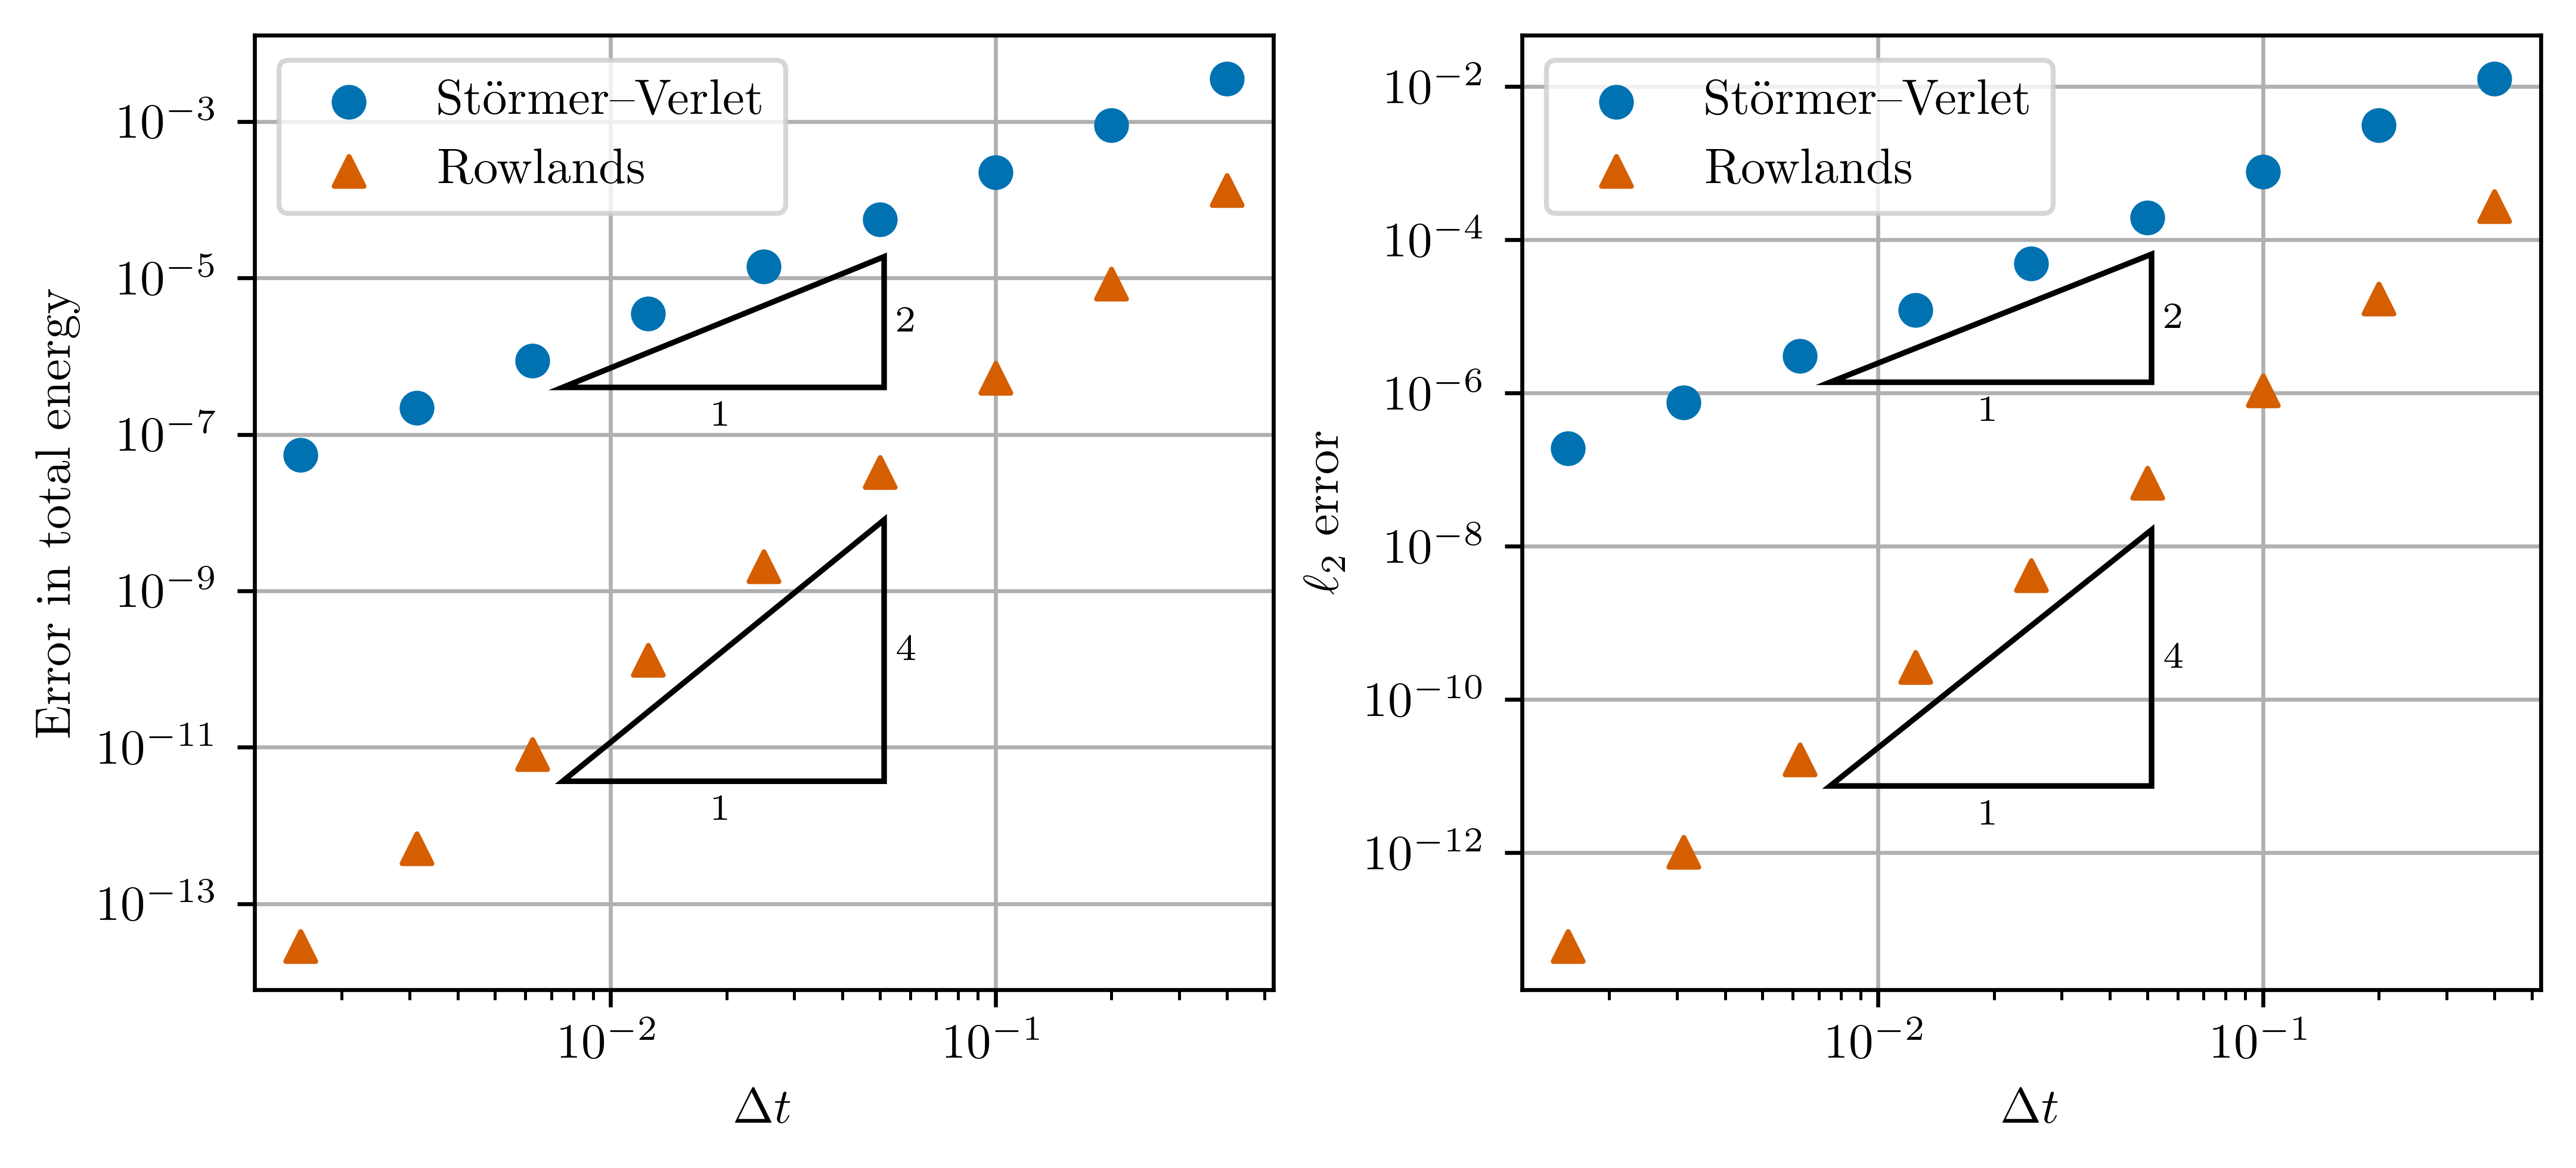

In [30]:
fig, axes = plt.subplots(1, 2,
                         figsize=(180 * mm_to_in, 80 * mm_to_in),
                         dpi=dpi,
                         constrained_layout=True,
                        )

ax = axes[0]

ax.grid()

ax.set_xscale('log')
ax.set_yscale('log')

log_log_origins = []

for post_i, name, ls, marker, alpha, c in zip(posts, names, line_styles, markers, alphas, colorscheme):
    E_tot_err_i_ = np.zeros((len(Dt_i_))) * np.nan

    for i, post in enumerate(post_i):
        if 'unproc' in name:
            print('unproc')
            E_tot_err_i_[i] = np.array([
                np.abs(post_ref.E_tot_[-1] - post.E_tot_Rowlands_[-1]),
            ])
            print(post.E_tot_[-1], post.E_tot_Rowlands_[-1], post_ref.E_tot_[-1])
        else:
            E_tot_err_i_[i] = np.array([
                np.abs(post_ref.E_tot_[-1] - post.E_tot_[-1]),
            ])
            
    log_log_origins.append((1.2 * Dt_i_[-3], 1/2.2 * E_tot_err_i_[-3]))
        
    ax.scatter(
        Dt_i_,
        E_tot_err_i_,
        label=name,
        ls=ls,
        marker=marker,
        alpha=alpha,
        color=c
    )
    
for origin, slope in zip(log_log_origins, slopes):
    draw_loglog_slope(fig, ax, origin=origin, width_inches=20*mm_to_in, slope=slope, color='k', inverted=False)

ax.legend()
ax.set_xlabel(r'$\Delta{t}$')
ax.set_ylabel(r'Error in total energy')

ax.set_axisbelow(True)

###

ax = axes[1]

ax.grid()

ax.set_xscale('log')
ax.set_yscale('log')

log_log_origins = []

for post_i, name, ls, marker, alpha, c in zip(posts, names, line_styles, markers, alphas, colorscheme):
    err_L2_i_ = np.zeros((len(Dt_i_))) * np.nan

    for i, post in enumerate(post_i):
        # print("{0:0.02f}, {1:0.02f}, {2:0.02f}".format(Dt_i_[i], post.tn_[-1], post_ref.tn_[-1]))
        # print(Dt_i_[i], post.tn_[-1], post_ref.tn_[-1])
        err_L2_i_[i] = np.sqrt(np.sum(np.array([
            np.abs(post_ref.x_n_[-1] - post.x_n_[-1]),
            np.abs(post_ref.y_n_[-1] - post.y_n_[-1]),
            np.abs(post_ref.p_x_n_[-1] - post.p_x_n_[-1]),
            np.abs(post_ref.p_y_n_[-1] - post.p_y_n_[-1]),
        ])**2))
        
    # print()
    
    log_log_origins.append((1.2 * Dt_i_[-3], 1/2.2 * err_L2_i_[-3]))
    
    ax.scatter(
        Dt_i_,
        err_L2_i_,
        label=name,
        ls=ls,
        marker=marker,
        alpha=alpha,
        color=c
    )
    
for origin, slope in zip(log_log_origins, slopes):
    draw_loglog_slope(fig, ax, origin=origin, width_inches=20*mm_to_in, slope=slope, color='k', inverted=False)

ax.legend()
ax.set_xlabel(r'$\Delta{t}$')
ax.set_ylabel(r'$\ell_2$ error')

ax.set_axisbelow(True)

plt.savefig('rowlands_convergence.png', facecolor='w', bbox_inches='tight')

plt.show()